In [1]:
"""
Creating functions that simulate ARMA processes

#### Arguments

`Ρ` : Vector of AR coeffecients
`Θ` : Vector of MA coeffecients
`sigma` : Standard Deviation of ARMA error components
`n` : Number of simulations
"""
function ARMA_sim(Ρ::AbstractVector, Θ::AbstractVector, sigma::Real,n::Int64)
    N_Ρ = length(Ρ)
    N_Θ = length(Θ)
    m = maximum([N_Θ, N_Ρ]) + 100
    
    Ε = rand(Normal(0.0,  sigma), (m + n))
    X = zeros((m + n))
    for i in (m-97):(m+n)
        X[i] = dot(X[(m-97 - N_Ρ):(m-98)], Ρ) + dot(Ε[(m-97 - N_Θ):(m-98)], Θ) + Ε[i]
    end
    X_1 = copy(X[(m + 1):(m+ n)])
    return X_1
end

    



ARMA_sim

In [2]:
using Distributions
using QuantEcon
using NLopt
#inputting parameter values for estimation 
ρ = 0.5
σ = 1.0
n = 500
lp = ARMA(ρ, 0, σ)

#Generating AR(1) process
X = ARMA_sim([0.5], [0.0], σ,n)

#Generating initial Guesses
α_0 = 1.0
P_0 = 2.0

#Inputting Harvey's coefficients for known values
Z = 1
H = 0

#creating empty grids for our estimation of the AR(1) process

P= zeros(n)
Pt_t_1 = zeros(n)
F = zeros(n)
v = zeros(n)

P_t_lag(T,p,q) = T*p*T' + q
F_t(z,t,p,q,h) = z*P_t_lag(t,p,q)*z' + h
α_t_lag(t,α) = t*α
v_t(x,z,t,α) = x - z*α_t_lag(t,α)
α_t( t, p, q, h, z, x, α) = α_t_lag(t,α) + P_t_lag(t,p,q)*z*((F_t(z,t,p,q,h))^(-1))*(v_t(x,z,t,α))
P_t(t,p,q, h, z) = P_t_lag(t,p,q) - P_t_lag(t,p,q)*z*((F_t(z,t,p,q,h))^(-1))*z*P_t_lag(t,p,q)

l(N,T, Ρ, Q, x, α, z,h) = -(N/2)*log(2*pi) - 0.5*log(abs(F_t(z,T,P,Q,h))) -0.5*(v_t(x, Z, T, α))'*((F_t(z,T,P,Q,h))^(-1))*(v_t(x, Z, T, α)) 

function L_lik(N,T, Ρ_init, Q, x, α_init, z,h)

    #array for unconditional P
    P = zeros(N)
    #array for unconditional α
    Α = zeros(N)

    
    L_sum = l(N, T, Ρ_init, Q, x[1], α_init, z,h)
    P[1] = P_t_lag(T,Ρ_init, Q)
    Α[1] = α_t(T,Ρ_init, Q, h, z, x, α_init)

    for k in 2:N
        L_sum += l(N, T,P[k-1], Q,x[k], Α[k-1], z, h)
        P[k] = P[1] = P_t_lag(T,P[k-1], Q)
        Α[k] = α_t(T,P[k-1], Q, h, z, x, Α[k-1] )
    end
    L_sum
end
    

function L_obj(x::Vector, grad::Vector)
    if length(grad) > 0
        grad[1] = 0
        grad[2] = 0
    end
    L_lik(n,x[1], P_0, x[2], X, α_0, Z,H)
end
opt1 = Opt(:LN_NELDERMEAD, 2)
lower_bounds!(opt1, [0.000000001,0.0])
max_objective!(opt1, L_obj)
(maxl,maxx, ret) = optimize(opt1, [1.0,1.0])
T = maxx[1]
Q = maxx[2]







in callback catch


LoadError: DomainError:

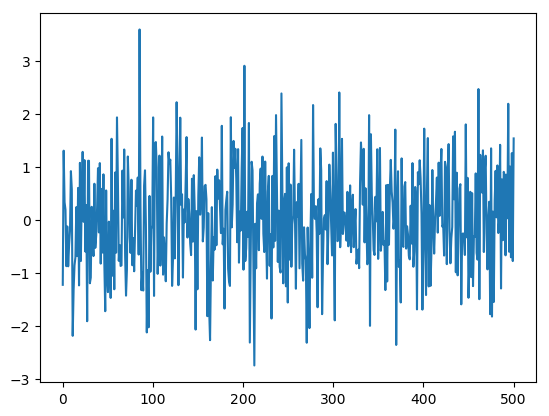

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000002AA4E518>

In [3]:
using PyPlot
plot(linspace(0,n,n), X)

In [4]:
#try rerunning again

#Using QuantEcon's ARMA distribution simulator to test algorithom

using Distributions
using QuantEcon
#inputting parameter values for estimation 
ρ = 0.5
σ = 1
n = 500
lp = ARMA(ρ, 0, σ)

#Generating AR(1) process
X = ARMA_sim([0.5], [0.0], σ,n)

#Generating initial Guesses
α_0 = 1.0
P_0 = 2.0

#Inputting Harvey's coefficients for known values
Z = 1
H = 0

#creating empty grids for our estimation of the AR(1) process
Α = zeros(n)
Αt_t_1 = zeros(n)

P= zeros(n)
Pt_t_1 = zeros(n)
F = zeros(n)
v = zeros(n)


p(t,p0,q) = t*p0*t' + q

#creating log likelihood

l(N,T, Ρ, Q, x, α) = -(N/2)*log(2*pi) - 0.5*log(abs(Z*p(T,Ρ,Q)*Z' + H)) -0.5*(x - Z*T*α)'*inv(Z*p(T,Ρ,Q)*Z' + H)*(x - Z*T*α) 
T_grid = linspace(0,1,100)
Q_grid = linspace(0,5,100)
L = zeros(100,100)
L_dic = Dict()

#performing MLE for t = 1
function L_obj(x::Vector, grad::Vector)
    if length(grad) > 0
        grad[1] = 0
        grad[2] = 0
    end
    l(1, x[1], P_0, x[2], X, α_0)
end

opt1 = Opt(:LN_NELDERMEAD, 2)
lower_bounds!(opt1, [0.0,0.0])
max_objective!(opt1, L_obj)
(maxl,maxx, ret) = optimize(opt1, [1.0,1.0])

T = maxx[1]
Q = maxx[2]

##Note to self, need to perform MLE for estimates of T and Q, probably use NLopt package

in callback catch


LoadError: MethodError: Cannot `convert` an object of type Array{Float64,1} to an object of type Float64
This may have arisen from a call to the constructor Float64(...),
since type constructors fall back to convert methods.

In [5]:
#creating first element
Αt_t_1[1] = T*α_0
Pt_t_1[1] = T*P_0*T' + Q

v[1] = X[1] - Z*Αt_t_1[1]
F[1] = Z*Pt_t_1[1]*Z + H

Α[1] = Αt_t_1[1] + Pt_t_1[1]*Z'*inv(Z*Pt_t_1[1]*Z' + H)*(X[1] - Z*Αt_t_1[1])

P[1] = Pt_t_1[1] - Pt_t_1[1]*Z'*inv(Z*Pt_t_1[1]*Z' + H)*Z*Pt_t_1[1]



for k in 2:n
    L = zeros(100,100)
    L_dic = Dict()
    function L_obj(x::Vector, grad::Vector)
        if length(grad) > 0
            grad[1] = 0
            grad[2] = 0
        end
        L_sum = l(k, x[1], P_0, x[2], X[1], α_0)
        for h in 2:k
            L_sum += l(k, x[1], Pt_t_1[h-1], x[2], X[h], Α[h-1])
        end
        L_sum
    end
    opt1 = Opt(:LN_NELDERMEAD, 2)
    lower_bounds!(opt1, [0.000000001,0.0])
    max_objective!(opt1, L_obj)
    (maxl,maxx, ret) = optimize(opt1, [1.0,1.0])
    T = maxx[1]
    Q = maxx[2]
    
    Αt_t_1[k] = T*Α[k-1]
    Pt_t_1[k] = T*P[k-1]*T' + Q

    v[k] = X[k] - Z*Αt_t_1[k]
    F[k] = Z*Pt_t_1[k]*Z + H

    Α[k] = Αt_t_1[k] + Pt_t_1[k]*Z'*inv(Z*Pt_t_1[k]*Z' + H)*(X[k] - Z*Αt_t_1[k])

    P[k] = Pt_t_1[k] - Pt_t_1[k]*Z'*inv(Z*Pt_t_1[k]*Z' + H)*Z*Pt_t_1[k]
end

        




{T<:Any, 1}) in module Main at In[2]:59 overwritten at In[4]:46.


LoadError: UndefVarError: T not defined

In [6]:
T

LoadError: UndefVarError: T not defined

In [7]:
using PyPlot

plot(linspace(1,100,100), Y)
plot(linspace(1,100,100), Α)

LoadError: UndefVarError: Y not defined

In [8]:
plot(linspace(1,100,100), XY)

LoadError: UndefVarError: XY not defined

In [9]:

XY = ARMA_sim([0.5], [0.0], σ,n)

500-element Array{Float64,1}:
 -1.22898 
 -0.201823
 -0.369606
  0.732813
 -0.594336
  0.217901
  1.20836 
 -1.45264 
  0.637361
 -1.25207 
  1.22176 
 -0.106646
  0.10194 
  ⋮       
 -0.900211
 -0.45082 
 -0.381108
  0.107007
 -0.30466 
  0.571049
 -0.218851
  0.677045
 -0.215514
 -0.935409
 -0.961316
  0.579015

In [10]:
inv(1)

1.0

In [11]:
using JuMP

m = Model()
variable(m, 0 <= x  )
variable(m, 0 <= y  )

objective(m, Max, l(1.0, x, P_0, y, X[1], α_0) )


print(m)

status = solve(m)



LoadError: UndefVarError: variable not defined

In [12]:
using JuMP, CoinOptServices
m = Model(solver = OsilBonminSolver())


@variable(m, 0 <= x <= 2 )
@variable(m, 0 <= y <= 30 )

@objective(m, Max, 5x + 3*y )
@constraint(m, 1x + 5y <= 3.0 )

print(m)

status = solve(m)

Max 5 x + 3 y
Subject to
 x + 5 y <= 3
 0 <= x <= 2
 0 <= y <= 30


LoadError: UndefVarError: solve not defined

In [13]:
using NLopt

In [14]:
using NLopt 
function f( x::Vector, grad::Vector) 
    if length(grad) > 0
        grad[1] = -5 
        grad[2] = -3
    end
    -5*x[1] - 3*x[2]
end
opt = Opt(:LN_NELDERMEAD, 2)
lower_bounds!(opt, [0.0,0.0])
upper_bounds!(opt, [2.0,30.0])
max_objective!(opt, f)

(optf,optx, ret) = optimize(opt, [1.0,1.0])


(-0.0,[0.0,0.0],:XTOL_REACHED)

In [15]:
function L_obj(x::Vector, grad::Vector)
    if length(grad) > 0
        grad[1] = 0
        grad[2] = 09
    end
    l(1, x[1], P_0, x[2], X[1], α_0)
end

opt1 = Opt(:LN_NELDERMEAD, 2)
lower_bounds!(opt1, [0.0,0.0])
max_objective!(opt1, L_obj)
(maxl,maxx, ret) = optimize(opt1, [1.0,1.0])

(-1.656470792820929,[0.0,1.60812],:XTOL_REACHED)

In [16]:
T

{T<:Any, 1}) in module Main at In[4]:46 overwritten at In[15]:2.


LoadError: UndefVarError: T not defined

In [17]:
Q

LoadError: UndefVarError: Q not defined

In [18]:
[2 0; 0 2]^(-1)

2×2 Array{Float64,2}:
 0.5  0.0
 0.0  0.5